# Read dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Train.csv').values
test_data = pd.read_csv('./dataset/Google_Stock_Price/Google_Stock_Price_Test.csv').values

# parameter
input_days = 10
local_norm_flag = True
epochs = 1000
batch_size = 500
period = 100
offset = 0.5
RADAM = True
if RADAM:
    from keras_radam import RAdam
    from keras_lookahead import Lookahead
    optimizer = Lookahead(RAdam())
else:
    optimizer = 'sgd'

Instructions for updating:
Colocations handled automatically by placer.


# Fix data string to float

In [2]:
# the data[4:6] must be fix
def str2float(data):
    length = len(data)
    for i in range(length):
        try:
            data[i] = data[i].replace(',', '')
        except AttributeError:
            data[i] = data[i]
    return np.asarray(data, dtype=np.float)
    
# fix all data in dataset
def fixStr2Float(dataset):
    shape = dataset.shape
    dataset_t = np.zeros((0, shape[-1]), np.float)
    for i, data in enumerate(dataset):
        dataset_t = np.append(dataset_t, np.expand_dims(str2float(data), axis=0), axis=0)
    return dataset_t

# trainsform
train_data_t = fixStr2Float(train_data[:, 1:])
test_data_t = fixStr2Float(test_data[:, 1:])

print(train_data_t.shape)
print(test_data_t.shape)

(1258, 5)
(20, 5)


# My own MinMaxScaler

In [3]:
class MinMaxScaler:
    __min = 0.
    __max = 1.
    __range = 1.
    __feature_range = (0, 1)
    __scale = 1.
    def __init__(self):
        pass
    def getScalerData(self, dataset, offset=0.1, feature_range=(0, 1)):
        data_max = np.max(dataset)
        data_min = np.min(dataset)
        if len(dataset) == 1:
            range_temp = dataset * offset
        else:
            range_temp = (data_max - data_min) * (1 + offset)
        self.__min = data_max - range_temp
        self.__max = data_min + range_temp
        self.__range = self.__max - self.__min
        self.__feature_range = feature_range
        self.__scale = (feature_range[1] - feature_range[0]) / self.__range
        return self.getTransformData(dataset)
    def getTransformData(self, dataset):
        return (dataset - self.__min) * self.__scale + self.__feature_range[0]
    def getInverseData(self, scalerDataset):
        return (scalerDataset - self.__feature_range[0]) / self.__scale + self.__min
    def getParameter(self):
        return self.__min, self.__max, self.__range, self.__feature_range, self.__scale
    def updatePatameter(self, parameter):
        self.__min, self.__max, self.__range, self.__feature_range, self.__scale = parameter

# define create dataset

In [4]:
def createDataset_global(dataset, day_in=60, day_out=1):
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(dataset[i-day_in:i, :])
        y.append(dataset[i:i+day_out, :])
    return np.asarray(x), np.asarray(y)

def genQuteChange(dataset):
    return (dataset[1:] - dataset[:-1]) / dataset[:-1]

def createDataset_local(dataset, day_in=60, day_out=1, offset=0.1):
    sc = MinMaxScaler()
    count = len(dataset)
    x = []
    y = []
    for i in range(day_in, count - day_out + 1):
        x.append(sc.getScalerData(dataset[i-day_in:i, :], offset=offset))
        y.append(sc.getTransformData(dataset[i:i+day_out, :]))
    return np.asarray(x), np.asarray(y)

# Create training dataset and testing dataset

In [5]:
# append to a big dataset total
dataset = np.append(train_data_t, test_data_t, axis=0)
test_count = len(test_data_t)

# Split dataset to Volume and Open
open_data = dataset[:, :1]
volume_data = dataset[:, -1:]

# use global norm to volume data (with offset)
volume_sc = MinMaxScaler()
volume_norm = volume_sc.getScalerData(volume_data, offset=0.05, feature_range=(0, 1))

# create dataset
volume_dataset = createDataset_global(volume_norm, day_in=input_days)
if local_norm_flag:
    open_dataset = createDataset_local(dataset[:, :1], day_in=input_days, offset=offset)
else:
    open_sc = MinMaxScaler()
    open_qute = genQuteChange(dataset[:, :1])
    open_norm = open_sc.getScalerData(open_qute, offset=0, feature_range=(0, 1))
    open_dataset = createDataset_global(open_norm, day_in=input_days)
    # fix volume dataset
    volume_dataset = (volume_dataset[0][1:], volume_dataset[1][1:])

# create total dataset
dataset_x = np.append(open_dataset[0], volume_dataset[0], axis=-1)
dataset_y = np.append(open_dataset[1], volume_dataset[1], axis=-1)

# split to train and test dataset
train_x = dataset_x[:-test_count]
train_y = dataset_y[:-test_count, :, :1]
test_x = dataset_x[-test_count-input_days:]
test_y = dataset_y[-test_count-input_days:, :, :1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1248, 10, 2) (1248, 1, 1)
(30, 10, 2) (30, 1, 1)


# show volume data detail

[33.66417403] [-0.99747065]


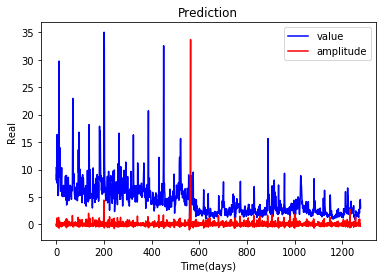

In [6]:
count = len(volume_data)
min_ = 1
max_ = 0
stat = []
sc = MinMaxScaler()
volume_data_temp = sc.getScalerData(volume_data, offset=0, feature_range=(0, 35))
for i in range(1, count):
    temp = (volume_data[i] - volume_data[i-1]) / volume_data[i-1]
    stat.append(temp[0])
    if temp > max_:
        max_ = temp
    elif temp < min_:
        min_ = temp
print(max_, min_)

# Visualising the results
plt.plot(volume_data_temp, color = 'blue', label = 'value')
plt.plot(stat, color = 'red', label = 'amplitude')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()

# Create Model

In [7]:
# LSTM Training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import plot_model

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_days, 2), dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(LSTM(units = 50, return_sequences = True, dropout=0.2))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dense(units = 40, activation='relu'))
model.add(Dense(units = 1))
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.summary()
plot_model(model, 'model.png')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               64128     
_________________________________________________________________
dense_1 (Dense)              (None, 40)      

# Training the model with `Open` data and `Volume` data

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os
name = 'LSTM_03'
checkpoint_file = './model/' + name + '_check_point/cp-{epoch:04d}.ckpt'
try:
    os.mkdir('./model/' + name + '_check_point/')
except:
    pass

# get what we want
train_input = train_x
train_label = train_y
test_input = test_x
test_label = test_y
train_label = np.squeeze(train_label, axis=1)
test_label = np.squeeze(test_label, axis=1)

# create callback function
cp_callback = ModelCheckpoint(checkpoint_file, save_weights_only=True, verbose=1, period=period)

# train the model
train = model.fit(train_input, train_label, epochs=epochs, batch_size=batch_size, callbacks=[cp_callback], 
                  validation_data=(test_input, test_label))

# save model
model.save('./model/' + name + '.h5')

Train on 1248 samples, validate on 30 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1248/1248 [==============================] - 2s 2ms/sample - loss: 0.3555 - val_loss: 0.7563
Epoch 2/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.3502 - val_loss: 0.7580
Epoch 3/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.3504 - val_loss: 0.7540
Epoch 4/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.3487 - val_loss: 0.7510
Epoch 5/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.3445 - val_loss: 0.7490
Epoch 6/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.3424 - val_loss: 0.7394
Epoch 7/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.3369 - val_loss: 0.7360
Epoch 8/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.3322 - val_loss: 0.7221
Epoch 9/1000
1248/1248 [====================

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0678 - val_loss: 0.3156
Epoch 74/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0678 - val_loss: 0.3122
Epoch 75/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0681 - val_loss: 0.3159
Epoch 76/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0662 - val_loss: 0.3179
Epoch 77/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0676 - val_loss: 0.3130
Epoch 78/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0663 - val_loss: 0.3140
Epoch 79/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0668 - val_loss: 0.3145
Epoch 80/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0663 - val_loss: 0.3122
Epoch 81/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0663 - val_loss: 0.3122
Epoch 82/1000
1248/1248 [========

1248/1248 [==============================] - 0s 125us/sample - loss: 0.0602 - val_loss: 0.2984
Epoch 140/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0597 - val_loss: 0.3003
Epoch 141/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0610 - val_loss: 0.2980
Epoch 142/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0596 - val_loss: 0.2974
Epoch 143/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0593 - val_loss: 0.3003
Epoch 144/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0589 - val_loss: 0.3004
Epoch 145/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0598 - val_loss: 0.2966
Epoch 146/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0598 - val_loss: 0.3006
Epoch 147/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0603 - val_loss: 0.3016
Epoch 148/1000
1248/1248 

Epoch 209/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0582 - val_loss: 0.2991
Epoch 210/1000
1248/1248 [==============================] - 0s 113us/sample - loss: 0.0582 - val_loss: 0.3004
Epoch 211/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0585 - val_loss: 0.2955
Epoch 212/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0595 - val_loss: 0.2959
Epoch 213/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0584 - val_loss: 0.2974
Epoch 214/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0592 - val_loss: 0.2988
Epoch 215/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0585 - val_loss: 0.2967
Epoch 216/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0586 - val_loss: 0.2977
Epoch 217/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0565 - val_loss: 0.2958
Epoch 218/

1248/1248 [==============================] - 0s 125us/sample - loss: 0.0570 - val_loss: 0.2931
Epoch 284/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0571 - val_loss: 0.2979
Epoch 285/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0579 - val_loss: 0.2947
Epoch 286/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0565 - val_loss: 0.2990
Epoch 287/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0570 - val_loss: 0.2973
Epoch 288/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0565 - val_loss: 0.2997
Epoch 289/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0568 - val_loss: 0.2975
Epoch 290/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0566 - val_loss: 0.2964
Epoch 291/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0556 - val_loss: 0.2985
Epoch 292/1000
1248/1248 

Epoch 353/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0484 - val_loss: 0.2898
Epoch 354/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0496 - val_loss: 0.3035
Epoch 355/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0496 - val_loss: 0.3068
Epoch 356/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0493 - val_loss: 0.2989
Epoch 357/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0480 - val_loss: 0.2963
Epoch 358/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0488 - val_loss: 0.2961
Epoch 359/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0475 - val_loss: 0.3057
Epoch 360/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0484 - val_loss: 0.2986
Epoch 361/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0476 - val_loss: 0.3007
Epoch 362/

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0433 - val_loss: 0.2819
Epoch 423/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0422 - val_loss: 0.2697
Epoch 424/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0417 - val_loss: 0.2781
Epoch 425/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0422 - val_loss: 0.2742
Epoch 426/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0403 - val_loss: 0.2934
Epoch 427/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0403 - val_loss: 0.2741
Epoch 428/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0451 - val_loss: 0.2710
Epoch 429/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0404 - val_loss: 0.2744
Epoch 430/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0406 - val_loss: 0.2771
Epoch 431/1000
1248/1248 

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0392 - val_loss: 0.2735
Epoch 497/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0406 - val_loss: 0.2852
Epoch 498/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0427 - val_loss: 0.2790
Epoch 499/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0405 - val_loss: 0.2808
Epoch 500/1000
 500/1248 [===========>..................] - ETA: 0s - loss: 0.0455
Epoch 00500: saving model to ./model/LSTM_03_check_point/cp-0500.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
1248/1248 [==============================] - 0s 200us/sample - loss: 0.0422 - val_loss: 0.2822
Epoch 501/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0409 - val_loss: 0.2805
Epoch 502/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0414 - val_loss: 0.2812
Epoch 503/1000
1248/1248 [=========================

Epoch 566/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0402 - val_loss: 0.2779
Epoch 567/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0374 - val_loss: 0.2891
Epoch 568/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0397 - val_loss: 0.2768
Epoch 569/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0399 - val_loss: 0.2814
Epoch 570/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0399 - val_loss: 0.2865
Epoch 571/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0388 - val_loss: 0.2792
Epoch 572/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0404 - val_loss: 0.2835
Epoch 573/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0406 - val_loss: 0.2822
Epoch 574/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0398 - val_loss: 0.2794
Epoch 575/

1248/1248 [==============================] - 0s 125us/sample - loss: 0.0396 - val_loss: 0.2892
Epoch 636/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0406 - val_loss: 0.2894
Epoch 637/1000
1248/1248 [==============================] - 0s 113us/sample - loss: 0.0394 - val_loss: 0.2826
Epoch 638/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0414 - val_loss: 0.2822
Epoch 639/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0401 - val_loss: 0.2891
Epoch 640/1000
1248/1248 [==============================] - 0s 113us/sample - loss: 0.0388 - val_loss: 0.2796
Epoch 641/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0386 - val_loss: 0.2921
Epoch 642/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0418 - val_loss: 0.2849
Epoch 643/1000
1248/1248 [==============================] - 0s 113us/sample - loss: 0.0390 - val_loss: 0.2762
Epoch 644/1000
1248/1248 

Epoch 705/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0404 - val_loss: 0.3033
Epoch 706/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0425 - val_loss: 0.2666
Epoch 707/1000
1248/1248 [==============================] - 0s 113us/sample - loss: 0.0404 - val_loss: 0.3047
Epoch 708/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0409 - val_loss: 0.2633
Epoch 709/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0391 - val_loss: 0.2954
Epoch 710/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0415 - val_loss: 0.2720
Epoch 711/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0397 - val_loss: 0.2880
Epoch 712/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0395 - val_loss: 0.2788
Epoch 713/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0413 - val_loss: 0.2738
Epoch 714/

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0401 - val_loss: 0.2731
Epoch 780/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0407 - val_loss: 0.2854
Epoch 781/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0398 - val_loss: 0.2901
Epoch 782/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0399 - val_loss: 0.2743
Epoch 783/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0394 - val_loss: 0.3057
Epoch 784/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0410 - val_loss: 0.2734
Epoch 785/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0383 - val_loss: 0.2967
Epoch 786/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0410 - val_loss: 0.2751
Epoch 787/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0398 - val_loss: 0.2901
Epoch 788/1000
1248/1248 

Epoch 849/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0396 - val_loss: 0.2798
Epoch 850/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0396 - val_loss: 0.2835
Epoch 851/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0394 - val_loss: 0.2720
Epoch 852/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0381 - val_loss: 0.2834
Epoch 853/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0383 - val_loss: 0.2749
Epoch 854/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0384 - val_loss: 0.2821
Epoch 855/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0406 - val_loss: 0.2887
Epoch 856/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0393 - val_loss: 0.2782
Epoch 857/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0391 - val_loss: 0.2905
Epoch 858/

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0394 - val_loss: 0.2721
Epoch 919/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0386 - val_loss: 0.2821
Epoch 920/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0393 - val_loss: 0.2828
Epoch 921/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0407 - val_loss: 0.2767
Epoch 922/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0397 - val_loss: 0.2803
Epoch 923/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0389 - val_loss: 0.2736
Epoch 924/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0381 - val_loss: 0.2859
Epoch 925/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0375 - val_loss: 0.2746
Epoch 926/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0400 - val_loss: 0.2856
Epoch 927/1000
1248/1248 

1248/1248 [==============================] - 0s 138us/sample - loss: 0.0397 - val_loss: 0.2738
Epoch 993/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0394 - val_loss: 0.2841
Epoch 994/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0393 - val_loss: 0.2777
Epoch 995/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0378 - val_loss: 0.2825
Epoch 996/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0388 - val_loss: 0.2824
Epoch 997/1000
1248/1248 [==============================] - 0s 125us/sample - loss: 0.0383 - val_loss: 0.2833
Epoch 998/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0381 - val_loss: 0.2930
Epoch 999/1000
1248/1248 [==============================] - 0s 138us/sample - loss: 0.0397 - val_loss: 0.2753
Epoch 1000/1000
 500/1248 [===========>..................] - ETA: 0s - loss: 0.0433
Epoch 01000: saving model to ./model/LSTM_03_check_

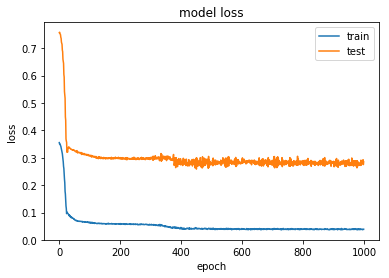

In [9]:
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [10]:
# local data
# model.load_weights('./model/LSTM_03_check_point/cp-{epoch:04d}.ckpt'.format(epoch=600))
if local_norm_flag:
    testing_data = open_data[-test_count-input_days:]
    output_prices = []
    for i in range(test_count):
        sc = MinMaxScaler()
        test = testing_data[i:i+input_days]
        test = sc.getScalerData(test, offset=offset)
        output = model.predict(np.append(np.expand_dims(test, axis=0), test_x[i:i+1, :, 1:2], axis=-1))
        output_prices.append(sc.getInverseData(output[0][0]))
else:
    output = model.predict(test_input)
    output_qute = 1 + open_sc.getInverseData(output)[-test_count:]
    value_init = open_data[-test_count-1:-1]
    output_prices = value_init * output_qute
output_prices = np.asarray(output_prices)
print(output_prices.shape, output_prices)

(20,) [781.38037627 777.96356681 783.53069614 783.95978458 791.14662736
 803.36596461 803.94513478 799.24824469 798.45378062 798.525732
 798.69100163 799.62576529 799.46177803 803.81199664 806.74995209
 820.14866334 827.76285383 834.87086449 832.11521305 816.51730545]


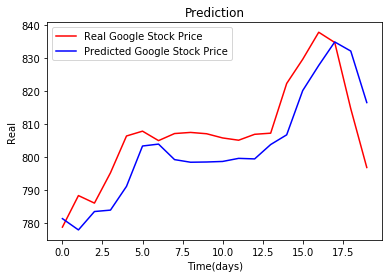

In [11]:
# Visualising the results
plt.plot(test_data_t[:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Prediction')
plt.xlabel('Time(days)')
plt.ylabel('Real')
plt.legend()
plt.show()

In [12]:
# local data
# model.load_weights('./model/LSTM_03_check_point/cp-{epoch:04d}.ckpt'.format(epoch=600))
if local_norm_flag:
    train_count = len(train_data_t) - input_days
    testing_data = open_data[:-test_count]
    output_prices = []
    for i in range(train_count):
        sc = MinMaxScaler()
        test = testing_data[i:i+input_days]
        test = sc.getScalerData(test, offset=offset)
        output = model.predict(np.append(np.expand_dims(test, axis=0), train_x[i:i+1, :, 1:2], axis=-1))
        output_prices.append(sc.getInverseData(output[0][0]))
    output_prices = np.asarray(output_prices)
    print(output_prices.shape, output_prices)

(1248,) [314.7193744  313.45442601 315.93532314 ... 790.39947988 792.14086123
 782.11357543]


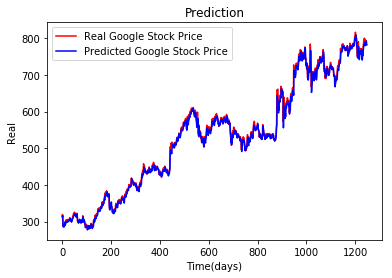

In [13]:
# Visualising the results
if local_norm_flag:
    plt.plot(train_data_t[input_days:, 0], color = 'red', label = 'Real Google Stock Price')
    plt.plot(output_prices, color = 'blue', label = 'Predicted Google Stock Price')
    plt.title('Prediction')
    plt.xlabel('Time(days)')
    plt.ylabel('Real')
    plt.legend()
    plt.show()